In [125]:
import pandas as pd
import geopandas
import seaborn as sns
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

The FSA map is from Canada Post - it's a set of geometry polygons for each Forward Sortation Area in the country.

In [126]:
FSA_map = geopandas.read_file('FSA_Shapefile')

In [127]:
#Filter down the FSA to only Ontario
FSA_map = FSA_map[FSA_map['PRUID'] == "35"]

In [128]:
FSA_map.head()

,CFSAUID,DGUID,PRUID,PRNAME,LANDAREA,geometry
643,K0A,2021A0011K0A,35,Ontario,3072.8212,"MULTIPOLYGON (((7409003.466 1184446.8, 7409023..."
644,K0B,2021A0011K0B,35,Ontario,1223.8974,"POLYGON ((7547053.517 1235912.877, 7546990.603..."
645,K0C,2021A0011K0C,35,Ontario,2470.9420,"MULTIPOLYGON (((7526037.231 1142505.114, 75260..."
646,K0E,2021A0011K0E,35,Ontario,1979.2436,"MULTIPOLYGON (((7467094.206 1056970.191, 74670..."
647,K0G,2021A0011K0G,35,Ontario,2675.2361,"MULTIPOLYGON (((7486734.166 1157795.989, 74867..."


Now we get census data at the FSA level - this is a monster file that contains data for every single FSA in the country, so we're going to need to get it down to a manageable size pretty quickly.

In [129]:
Census_data = pd.read_csv('98-401-X2021013_English_CSV_data.csv', encoding='latin-1')

In [130]:
SW_ON_Census_Data = Census_data.loc[Census_data['GEO_NAME'].str.match(r'[MN]\d\w', na=False)]

In [131]:
SW_ON_Census_Data = SW_ON_Census_Data[SW_ON_Census_Data['CHARACTERISTIC_ID'] == 1]

In [132]:
Filtered_SW_ON_Census_Data = SW_ON_Census_Data[['GEO_NAME', 'C1_COUNT_TOTAL']]

In [133]:
Filtered_SW_ON_Census_Data = Filtered_SW_ON_Census_Data.rename(columns={
    'GEO_NAME': 'FSA',
    'C1_COUNT_TOTAL': '2021 Population'
})

In [134]:
Filtered_SW_ON_Census_Data.set_index('FSA')

,2021 Population
FSA,
M1B,65555.0
M1C,35642.0
M1E,48033.0
M1G,30894.0
M1H,23964.0
...,...
N9H,13173.0
N9J,20089.0
N9K,2757.0


Lets look at the distribution a little bit

<Axes: >

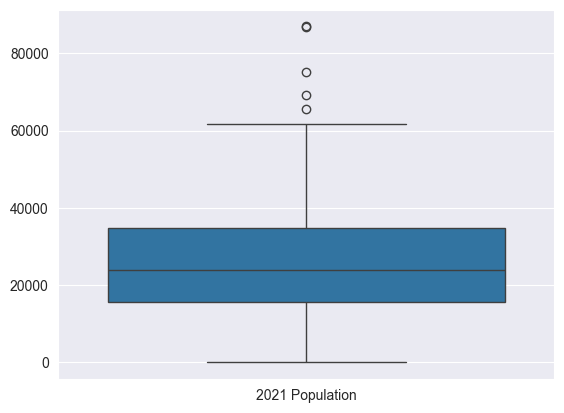

In [135]:
sns.boxplot(Filtered_SW_ON_Census_Data)

<Axes: ylabel='Count'>

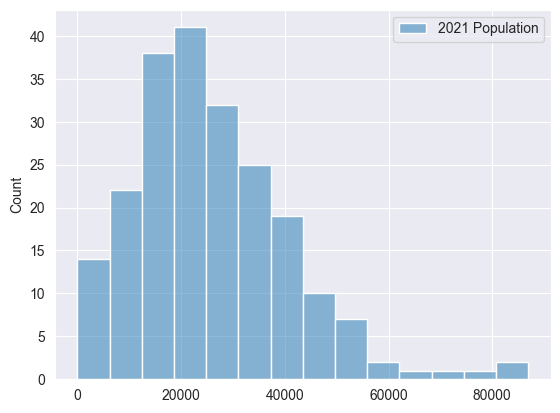

In [136]:
sns.histplot(Filtered_SW_ON_Census_Data, kde=False)

Now we can make a multiplier per 1000 population to start normalizing everything else to.

In [137]:
Filtered_SW_ON_Census_Data['Per 1000 Multiplier'] = 1000 / Filtered_SW_ON_Census_Data['2021 Population']

Great - now let's pull in the COVID case data. This comes from the City of Toronto, and has a row for each case that includes the FSA (see a pattern yet?), the date of the case, as well as a few flags for signs of a more serious case such as intubation and hospital or ICU admission.

In [138]:
covid_cases = pd.read_csv('COVID19 cases.csv')

In [139]:
covid_cases_2020 = covid_cases[covid_cases['Episode Date'] < '2021-01-01']

In [140]:
covid_cases_2020.head()

,_id,Assigned_ID,Outbreak Associated,Age Group,Neighbourhood Name,FSA,Source of Infection,Classification,Episode Date,Reported Date,Client Gender,Outcome,Ever Hospitalized,Ever in ICU,Ever Intubated
0,1,1,NO,50 to 59 Years,Willowdale East,M2N,Travel,CONFIRMED,2020-01-22,2020-01-23,FEMALE,RESOLVED,No,No,No
1,2,2,NO,50 to 59 Years,Willowdale East,M2N,Travel,CONFIRMED,2020-01-21,2020-01-23,MALE,RESOLVED,Yes,No,No
2,3,3,NO,20 to 29 Years,Parkwoods-Donalda,M3A,Travel,CONFIRMED,2020-02-05,2020-02-21,FEMALE,RESOLVED,No,No,No
3,4,4,NO,60 to 69 Years,Church-Yonge Corridor,M4W,Travel,CONFIRMED,2020-02-16,2020-02-25,FEMALE,RESOLVED,No,No,No
4,5,5,NO,60 to 69 Years,Church-Yonge Corridor,M4W,Travel,CONFIRMED,2020-02-20,2020-02-26,MALE,RESOLVED,No,No,No


In [141]:
covid_cases_2020.value_counts('Age Group')

Age Group
20 to 29 Years    13318
30 to 39 Years    11082
50 to 59 Years     9876
40 to 49 Years     9488
19 and younger     8093
60 to 69 Years     6323
80 to 89 Years     3325
70 to 79 Years     3320
90 and older       2177
Name: count, dtype: int64

In [142]:
age_percentages = covid_cases_2020.value_counts('Age Group', normalize = True)
age_counts = covid_cases_2020.value_counts('Age Group')

In [143]:
Age_table = pd.merge(left = age_percentages, right = age_counts, on = 'Age Group')

In [144]:
Age_table

,proportion,count
Age Group,,
20 to 29 Years,0.198770,13318
30 to 39 Years,0.165398,11082
50 to 59 Years,0.147399,9876
40 to 49 Years,0.141608,9488
19 and younger,0.120787,8093
60 to 69 Years,0.094370,6323
80 to 89 Years,0.049625,3325
70 to 79 Years,0.049551,3320
90 and older,0.032492,2177


In [145]:
percentages = covid_cases_2020.value_counts('Client Gender', normalize = True)
counts = covid_cases_2020.value_counts('Client Gender')

In [146]:
Gender_Table = pd.merge(left = percentages, right = counts, on = 'Client Gender')

In [147]:
Gender_Table['%'] = (Gender_Table['proportion'] * 100).round(1)

In [148]:
Gender_Table.drop('proportion', axis = 1, inplace = True)

In [149]:
Gender_Table

,count,%
Client Gender,,
FEMALE,34198,51.0
MALE,32585,48.6
UNKNOWN,234,0.3
OTHER,12,0.0
TRANSGENDER,9,0.0
NON-BINARY,1,0.0
TRANS WOMAN,1,0.0


In [150]:
# Do a bit of data wrangling - get the date column to be a date, and turn yes/no columns into 1/0 columns for later.

covid_cases['Episode Date'] = pd.to_datetime(covid_cases['Episode Date'])
cols_to_convert = ['Ever Hospitalized', 'Ever in ICU', 'Ever Intubated']
for col in cols_to_convert:
    covid_cases[col] = covid_cases[col].map({'Yes': 1, 'No': 0})

Lets take a look at how the data is distributed and see if there's anything fun to see.

In [151]:
FSA_Cases = covid_cases['FSA'].value_counts().to_frame()

<Axes: ylabel='Count'>

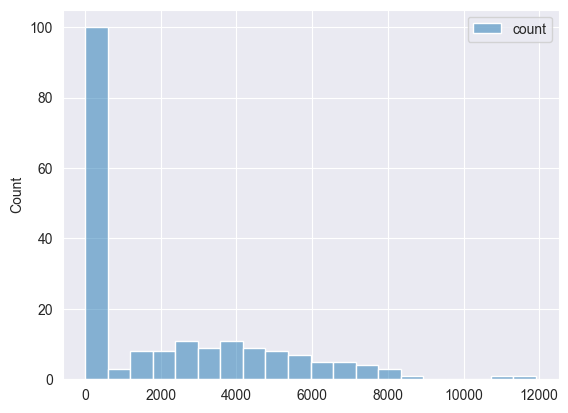

In [152]:
sns.histplot(FSA_Cases, bins=20)

Well that's...interesting - going in and looking at the data itself, there's a whole bunch of FSA with only a single case, and some hand checking reveals that they aren't real FSA's!

Lets see what FSA's in there don't appear in the official list

In [153]:
funky_FSA_codes = FSA_Cases[~FSA_Cases.index.isin(FSA_map['CFSAUID'])]

In [154]:
funky_FSA_codes['count'].sum()

np.int64(448)

Given that these funky (erroneous) FSA's are such a small group out of the whole number of cases, I'm just going to get rid of them. I'm guessing they must be a data entry problem since Canada post has no record of any of them and ultimately I can't match them.

In [155]:
Real_FSA_Cases = FSA_Cases[FSA_Cases.index.isin(FSA_map['CFSAUID'])]

In [156]:
Real_FSA_Cases.head()

,count
FSA,
M9V,11914
M1B,10949
M3N,8513
M9W,8177
M1P,7904


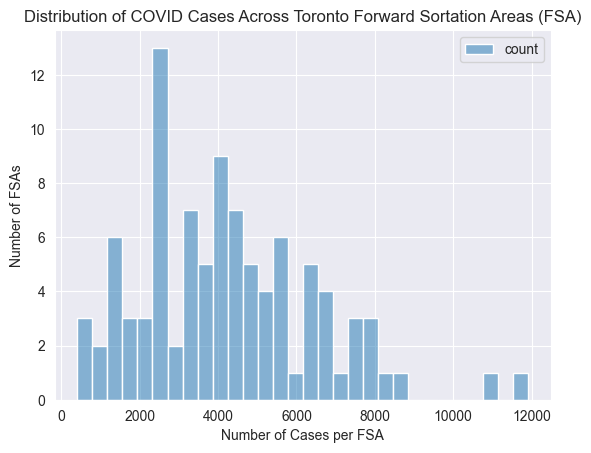

In [158]:
sns.histplot(Real_FSA_Cases, bins=30)
plt.xlabel('Number of Cases per FSA')
plt.ylabel('Number of FSAs')
plt.title('Distribution of COVID Cases Across Toronto Forward Sortation Areas (FSA)')
plt.show()

Aaah, that's better already. Dare I say it's getting closer to normal? - now let's adjust per 1000 and see what that gets us.

In [159]:
multiplier = Filtered_SW_ON_Census_Data.set_index('FSA')['Per 1000 Multiplier']

In [160]:
Real_FSA_Cases = Real_FSA_Cases.merge(
    multiplier,
    left_index=True,           # Use FSA index from Real_FSA_Cases
    right_on='FSA',           # Match with FSA column in multiplier
    how='left'                # Keep all rows from Real_FSA_Cases
)

In [161]:
Real_FSA_Cases['Covid Cases per 1000'] = Real_FSA_Cases['count'] * Real_FSA_Cases['Per 1000 Multiplier']


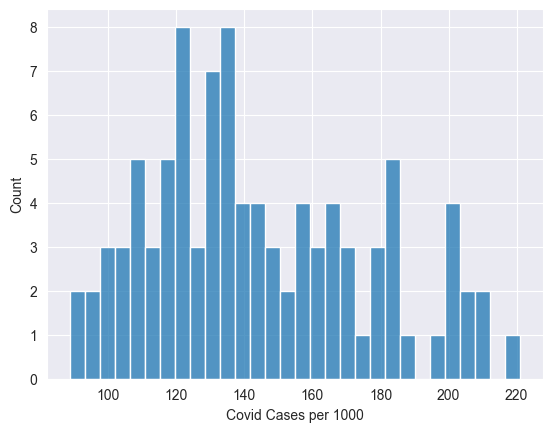

In [162]:
sns.histplot(data = Real_FSA_Cases, x = 'Covid Cases per 1000', bins=30)
plt.show()

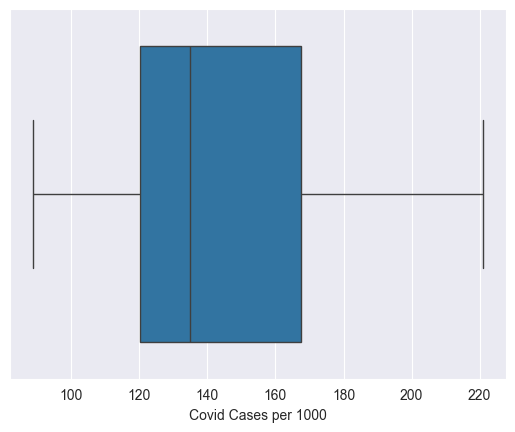

In [163]:
sns.boxplot(data = Real_FSA_Cases, x = 'Covid Cases per 1000')
plt.show()

Well that's lovely - I can work with that. Definitely some skew, but no outliers. Let's group our data weekly now to get it into a format we can begin comparing.

In [164]:
# Drop the non-real FSA's the same way we did on the area sums

covid_cases = covid_cases[covid_cases['FSA'].isin(FSA_map['CFSAUID'])]

In [165]:
covid_cases.shape

(406154, 15)

In [166]:
covid_weekly_cases = covid_cases.groupby([
    pd.Grouper(key = 'Episode Date', freq = 'W'),
    'FSA'
]).agg({
      'Ever Hospitalized': 'sum', # these sums work because 1 = True in here
    'Ever in ICU': 'sum',
    'Ever Intubated': 'sum',
    '_id': 'nunique' # _id is the unique case id - there's no patient level identifier so there's a possibility the same person with different
})

In [167]:
covid_weekly_cases.rename({'_id': 'Weekly Cases'}, axis=1, inplace=True)

In [168]:
columns_to_normalize = ['Weekly Cases', 'Ever Hospitalized', 'Ever in ICU', 'Ever Intubated']

for col in columns_to_normalize:
    new_col_name = f'{col} per 1000'
    covid_weekly_cases.loc[:, new_col_name] = covid_weekly_cases[col] * covid_weekly_cases.index.get_level_values('FSA').map(multiplier)

In [169]:
covid_weekly_cases.head()

Ever Hospitalized  Ever in ICU  Ever Intubated  \
Episode Date FSA                                                   
2020-01-26   M2N                  1            0               0   
             M5G                  0            0               0   
2020-02-02   M2L                  0            0               0   
             M6M                  0            0               0   
2020-02-09   M3A                  0            0               0   

                  Weekly Cases  Weekly Cases per 1000  \
Episode Date FSA                                        
2020-01-26   M2N             2               0.026631   
             M5G             1               0.102554   
2020-02-02   M2L             1               0.088700   
             M6M             1               0.023726   
2020-02-09   M3A             1               0.029103   

                  Ever Hospitalized per 1000  Ever in ICU per 1000  \
Episode Date FSA                                                     
2020-01-26   M2N                    0.013316                   0.0   
             M5G                    0.000000                   0.0   
2020-02-02   M2L                    0.000000                   0.0   
             M6M                    0.000000                   0.0   
2020-02-09   M3A                    0.000000                   0.0   

                  Ever Intubated per 1000  
Episode Date FSA                           
2020-01-26   M2N                      0.0  
             M5G                      0.0  
2020-02-02   M2L                      0.0  
             M6M                      0.0  
2020-02-09   M3A                      0.0

Okay, now getting the EMS calls - these are published by Toronto Paramedic Services, and give data on the FSA (there's definitely a pattern now), the dispatch triage priority, as well as a few other pieces. It comes in a big spreadsheet, so we're only going to pull the tab for 2020

In [170]:
EMS_calls = pd.read_excel('paramedic-services-incident-data-2017-2022.xlsx', sheet_name='2020')


In [171]:
EMS_calls.head()

,ID,Dispatch_Time,Incident_Type,Priority_Number,Units_Arrived_At_Scene,Forward_Sortation_Area
0,6659063,2020-03-16 17:04:01,Fire,1,14,M9W
1,6637804,2020-02-26 17:12:36,Medical,1,11,M5B
2,6829985,2020-09-02 02:04:06,Medical,1,10,M6E
3,6726730,2020-05-26 16:09:41,Medical,1,9,M5V
4,6761768,2020-06-30 05:02:40,Fire,3,9,M3J


In [172]:
EMS_calls.shape

(270600, 6)

In [173]:
EMS_calls.Forward_Sortation_Area.value_counts().get('-')

np.int64(70)

In [174]:
# there's 177 events where we don't have an FSA - just going to filter those out for lack of a better idea
EMS_calls = EMS_calls[EMS_calls.Forward_Sortation_Area != '-']

Toronto uses some funky priority codes, according to the readme from the dataset:

| Priority | Description |
|----------|-------------|
| 1        | Delta       |
| 3        | Charlie     |
| 4        | Bravo       |
| 5        | Alpha       |
| 9        | Echo        |
| 11       | Alpha1      |
| 12       | Alpha2      |
| 13       | Alpha3      |
| 14       | Code 2      |

Going to map these to a smaller list of readable values then get dummy variables to go along with them. Also taking out Code 2, since it's for scheduled transfers.



In [175]:
Priority_name_map = {
    9: 'Resuscitation',
    1: 'High',
    3: 'High',
    4: 'Low',
    5: 'Low',
    11: 'Low',
    12: 'Low',
    13: 'Low'
}

EMS_calls['Priority_Name'] = EMS_calls['Priority_Number'].map(Priority_name_map)

In [176]:
EMS_calls = pd.get_dummies(EMS_calls, columns = ['Priority_Name'])

In [177]:
Filtered_EMS_calls = EMS_calls[
    (EMS_calls['Incident_Type'] == 'Medical') &
    (EMS_calls['Units_Arrived_At_Scene'].between(1, 3, inclusive='both'))
]

In [178]:
Filtered_EMS_calls = Filtered_EMS_calls.rename(columns = {'Forward_Sortation_Area': 'FSA'})

In [179]:
Filtered_EMS_calls.shape

(253936, 9)

Now we can look at it and see if we're actually making sense now

In [180]:
FSA_Calls = Filtered_EMS_calls['FSA'].value_counts().to_frame()

<Axes: xlabel='count'>

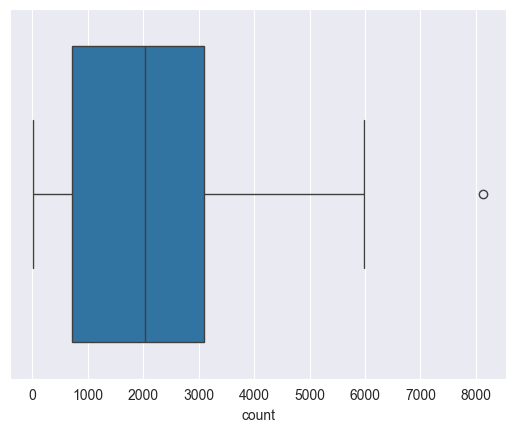

In [181]:
sns.boxplot(data = FSA_Calls, x = 'count')

<Axes: ylabel='Count'>

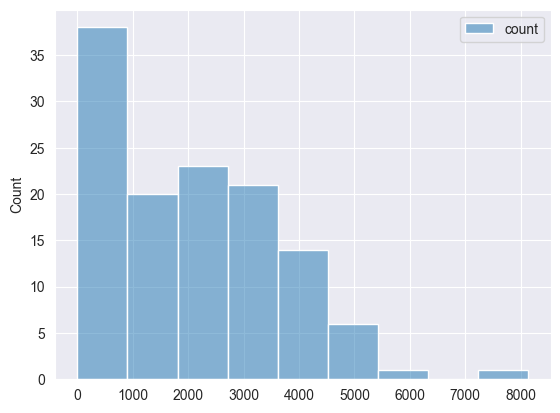

In [182]:
sns.histplot(data = FSA_Calls)

Well - that's a right skew for sure, let's normalize and see what we get

In [183]:
FSA_Calls.loc[:, 'EMS per 1000'] = FSA_Calls['count'] * FSA_Calls.index.map(multiplier)

<Axes: xlabel='EMS per 1000'>

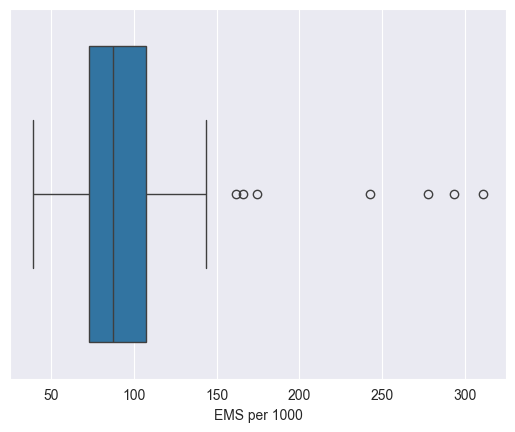

In [184]:
sns.boxplot(data = FSA_Calls, x = 'EMS per 1000')

Well that's better - a better distribution, though there's more outliers

In [185]:
EMS_weekly_cases = Filtered_EMS_calls.groupby([
    pd.Grouper(key='Dispatch_Time', freq='W'),
    'FSA'
]).agg({
    'ID': 'nunique',
    'Priority_Name_High' : 'sum',
    'Priority_Name_Low' : 'sum',
    'Priority_Name_Resuscitation' : 'sum'
}).reset_index()

In [186]:
covid_weekly_cases = covid_weekly_cases.rename({'Episode Date':'Week Start'},axis = 1)
EMS_weekly_cases = EMS_weekly_cases.rename({'Dispatch_Time':'Week Start', 'ID': 'EMS Calls'},axis = 1)

In [187]:
EMS_weekly_cases.loc[:, 'Weekly EMS Calls per 1000'] = EMS_weekly_cases['EMS Calls'] * EMS_weekly_cases['FSA'].map(multiplier)

In [188]:
EMS_weekly_cases.loc[:, '% of calls are High Acuity'] = (EMS_weekly_cases['Priority_Name_High'] + EMS_weekly_cases['Priority_Name_Resuscitation']) / EMS_weekly_cases['EMS Calls']


In [189]:
#Attach a geometry to each of these weeks
EMS_weekly_cases = EMS_weekly_cases.merge(FSA_map, left_on = 'FSA', right_on = 'CFSAUID', how = 'left')

In [190]:
gdf_EMS_weekly_cases = geopandas.GeoDataFrame(EMS_weekly_cases, geometry = 'geometry')

Now there's a stack of NaN in the new calls per 100 column - wonder if all the calls are actually in Toronto to get a number from?

<Axes: >

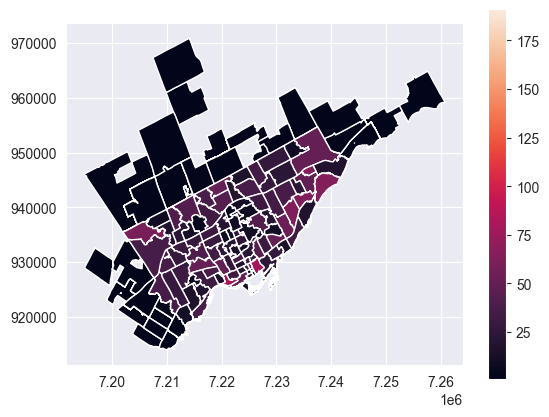

In [191]:
gdf_EMS_weekly_cases.plot(column = 'EMS Calls', legend = True)

Wait a second! There's way more there than just Toronto - lets filter it down. Looks like we can just drop columns where there wasn't a value since those are areas without pop data for Toronto itself.

In [192]:
EMS_weekly_cases = EMS_weekly_cases[EMS_weekly_cases['Weekly EMS Calls per 1000'].notna()]

Now we can actually merge our data and see things!

In [193]:
weekly_data = covid_weekly_cases.merge(EMS_weekly_cases, left_index = True, right_on =['Week Start', 'FSA'] )

In [194]:
weekly_data = weekly_data.set_index(['Week Start', 'FSA'])

<Axes: xlabel='Weekly Cases per 1000', ylabel='Weekly EMS Calls per 1000'>

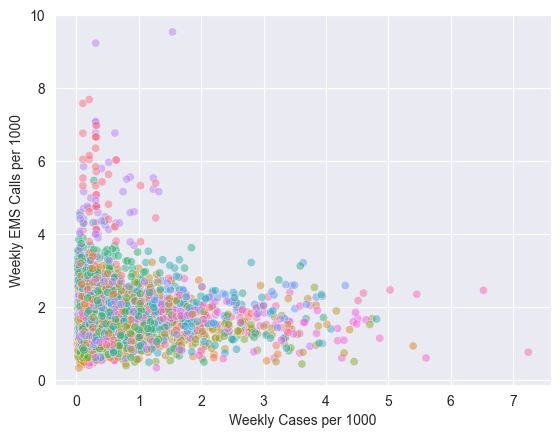

In [195]:
sns.scatterplot(weekly_data, x = 'Weekly Cases per 1000', y = 'Weekly EMS Calls per 1000', hue = 'FSA', legend = None, alpha = 0.5)

Well. We can see the baseline EMS volume, and an interesting pattern where certain FSA's appear to have a high base volume but relatively consistently low case volume. Let's look at some averages as time goes by.

<Axes: xlabel='Week Start'>

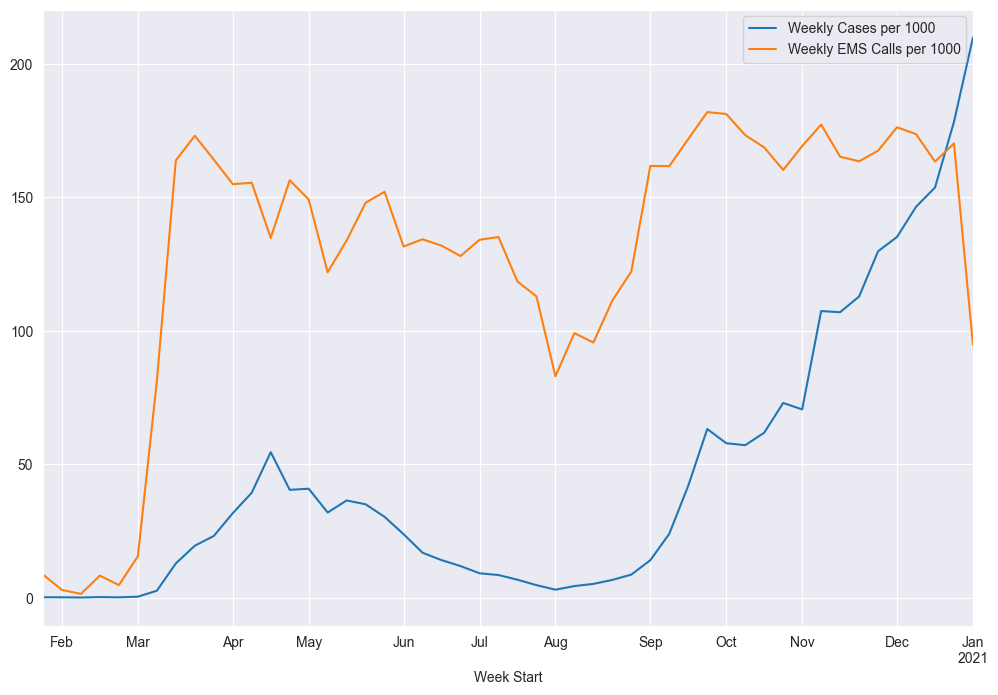

In [196]:
weekly_data.reset_index().groupby('Week Start').agg({
    'Weekly Cases per 1000': 'sum',
    'Weekly EMS Calls per 1000': 'sum'
}).plot(subplots=False, figsize=(12,8))

That looks like there might be something there - is there actually a correlation?

In [197]:
def calculate_weekly_stats(group):
    cases = group['Weekly Cases per 1000']
    ems_calls = group['Weekly EMS Calls per 1000']

    if len(cases) < 3:
        return pd.Series({'correlation': np.nan, 'p_value': np.nan})

    corr, p_val = pearsonr(cases, ems_calls)
    return pd.Series({'correlation': corr, 'p_value': p_val})

In [198]:
weekly_stats = weekly_data.groupby('Week Start').apply(calculate_weekly_stats)

In [199]:
weekly_stats

,correlation,p_value
Week Start,,
2020-01-26,NaN,NaN
2020-02-02,NaN,NaN
2020-02-09,NaN,NaN
2020-02-16,0.999426,5.740105e-04
2020-02-23,0.944763,2.125839e-01
2020-03-01,0.048430,8.943079e-01
2020-03-08,0.003822,9.803567e-01
2020-03-15,0.607724,2.260928e-09
2020-03-22,0.403910,5.945873e-05


This is the "answer" - there's 7 weeks where the correlation value is significant (< 0.05) , and of those weeks only 2 actually show a correlation value that suggests there is a correlation (> 0.5 or < -0.5). Interestingly, the significant weeks all appear to be in February, March, April and September. Lets look at doing a lag in either direction to see if there's a lag relationship.

In [200]:
weekly_data['Weekly Cases per 1000 Lag +1'] = weekly_data['Weekly Cases per 1000'].shift(1)
weekly_data['Weekly Cases per 1000 Lag -1'] = weekly_data['Weekly Cases per 1000'].shift(-1)

In [201]:
def calculate_weekly_stats_plus_one(group):
    cases = group['Weekly Cases per 1000 Lag +1']
    ems_calls = group['Weekly EMS Calls per 1000']

    if len(cases) < 3:
        return pd.Series({'correlation': np.nan, 'p_value': np.nan})

    corr, p_val = pearsonr(cases, ems_calls)
    return pd.Series({'correlation': corr, 'p_value': p_val})

In [202]:
weekly_stats_plus_one = weekly_data.groupby('Week Start').apply(calculate_weekly_stats_plus_one)

In [203]:
weekly_stats_plus_one

,correlation,p_value
Week Start,,
2020-01-26,NaN,NaN
2020-02-02,NaN,NaN
2020-02-09,NaN,NaN
2020-02-16,0.012403,0.987597
2020-02-23,-0.893468,0.296530
2020-03-01,-0.025808,0.943583
2020-03-08,-0.194424,0.205999
2020-03-15,0.168763,0.134534
2020-03-22,0.259238,0.012099


well that's ~~useless hot garbage~~ not statistically significant - let's look in the other direction

In [204]:
def calculate_weekly_stats_minus_one(group):
    cases = group['Weekly Cases per 1000 Lag -1']
    ems_calls = group['Weekly EMS Calls per 1000']

    if len(cases) < 3:
        return pd.Series({'correlation': np.nan, 'p_value': np.nan})

    corr, p_val = pearsonr(cases, ems_calls)
    return pd.Series({'correlation': corr, 'p_value': p_val})

In [205]:
weekly_stats_minus_one = weekly_data.groupby('Week Start').apply(calculate_weekly_stats_minus_one)

In [206]:
weekly_stats_minus_one

,correlation,p_value
Week Start,,
2020-01-26,NaN,NaN
2020-02-02,NaN,NaN
2020-02-09,NaN,NaN
2020-02-16,-0.020318,0.979682
2020-02-23,-0.188538,0.879251
2020-03-01,0.303357,0.394177
2020-03-08,-0.053746,0.728966
2020-03-15,0.479315,0.000007
2020-03-22,0.088893,0.396808


Again, not much there and any weeks with a significant p value are all correlation < 0.5 suggesting there's no correlation.

Let's look quickly at the FSA's and see if there's anything there, but I'm not really expecting anything given the summary doesn't see a correlation.

In [207]:
def calculate_fsa_correlation_and_pvalue(group):
    cases = group['Weekly Cases per 1000']
    ems_calls = group['Weekly EMS Calls per 1000']

    # Need at least 3 weeks of data for meaningful correlation
    if len(cases) < 3:
        return pd.Series({'correlation': np.nan, 'p_value': np.nan, 'n_weeks': len(cases)})

    corr, p_val = pearsonr(cases, ems_calls)
    return pd.Series({'correlation': corr, 'p_value': p_val, 'n_weeks': len(cases)})

In [208]:
fsa_stats = weekly_data.groupby('FSA').apply(calculate_fsa_correlation_and_pvalue)

In [209]:
fsa_stats

,correlation,p_value,n_weeks
FSA,,,
M1B,0.107927,0.490893,43.0
M1C,0.103237,0.515304,42.0
M1E,-0.012361,0.937293,43.0
M1G,0.289541,0.069957,40.0
M1H,0.074795,0.642103,41.0
...,...,...,...
M9N,-0.164486,0.291873,43.0
M9P,-0.040522,0.801393,41.0
M9R,-0.138262,0.376596,43.0


Interestingly, some areas where the result is definitely signficant, but nearly all have a correlation coefficient between 0.5 and -0.5 suggesting that the significant correlations are that there's no correlation.

For a final point, I want to also see if indicators of serious covid cases (Intubation, ICU admission, hospitalization) are related to high acuity EMS call volume. Intuitively I doubt it because the counts are so low (1.12 max), but you never know.

In [210]:
weekly_data['Serious Case Indicators per 1000'] = weekly_data[['Ever in ICU per 1000', 'Ever Intubated per 1000', 'Ever Hospitalized per 1000']].sum(axis=1)

In [211]:
filtered_weekly_data = weekly_data[(weekly_data['Serious Case Indicators per 1000'] > 0) & (weekly_data['EMS Calls'] > 10)]

In [212]:
filtered_weekly_data.head()

Ever Hospitalized  Ever in ICU  Ever Intubated  Weekly Cases  \
Week Start FSA                                                                 
2020-01-26 M2N                  1            0               0             2   
2020-02-23 M2N                  1            0               0             1   
2020-03-01 M6A                  1            1               1             1   
2020-03-08 M1B                  1            1               1             1   
           M1E                  1            0               0             1   

                Weekly Cases per 1000  Ever Hospitalized per 1000  \
Week Start FSA                                                      
2020-01-26 M2N               0.026631                    0.013316   
2020-02-23 M2N               0.013316                    0.013316   
2020-03-01 M6A               0.044683                    0.044683   
2020-03-08 M1B               0.015254                    0.015254   
           M1E               0.020819                    0.020819   

                Ever in ICU per 1000  Ever Intubated per 1000  EMS Calls  \
Week Start FSA                                                             
2020-01-26 M2N              0.000000                 0.000000         79   
2020-02-23 M2N              0.000000                 0.000000         93   
2020-03-01 M6A              0.044683                 0.044683         65   
2020-03-08 M1B              0.015254                 0.015254         95   
           M1E              0.000000                 0.000000         89   

                Priority_Name_High  ...  % of calls are High Acuity  CFSAUID  \
Week Start FSA                      ...                                        
2020-01-26 M2N                  39  ...                    0.518987      M2N   
2020-02-23 M2N                  50  ...                    0.537634      M2N   
2020-03-01 M6A                  28  ...                    0.461538      M6A   
2020-03-08 M1B                  48  ...                    0.536842      M1B   
           M1E                  41  ...                    0.494382      M1E   

                       DGUID  PRUID   PRNAME LANDAREA  \
Week Start FSA                                          
2020-01-26 M2N  2021A0011M2N     35  Ontario   9.5924   
2020-02-23 M2N  2021A0011M2N     35  Ontario   9.5924   
2020-03-01 M6A  2021A0011M6A     35  Ontario   5.5599   
2020-03-08 M1B  2021A0011M1B     35  Ontario  35.3539   
           M1E  2021A0011M1E     35  Ontario  15.8104   

                                                         geometry  \
Week Start FSA                                                      
2020-01-26 M2N  POLYGON ((7221634.897 942015.574, 7221671.577 ...   
2020-02-23 M2N  POLYGON ((7221634.897 942015.574, 7221671.577 ...   
2020-03-01 M6A  POLYGON ((7218978.851 936921.534, 7218984.82 9...   
2020-03-08 M1B  POLYGON ((7238905.477 952236.209, 7239316.163 ...   
           M1E  MULTIPOLYGON (((7239497.386 946350.946, 723952...   

               Weekly Cases per 1000 Lag +1  Weekly Cases per 1000 Lag -1  \
Week Start FSA                                                              
2020-01-26 M2N                          NaN                      0.102554   
2020-02-23 M2N                     0.019675                      0.065377   
2020-03-01 M6A                     0.016691                      0.023747   
2020-03-08 M1B                     0.041246                      0.028057   
           M1E                     0.028057                      0.041729   

               Serious Case Indicators per 1000  
Week Start FSA                                   
2020-01-26 M2N                         0.013316  
2020-02-23 M2N                         0.013316  
2020-03-01 M6A                         0.134048  
2020-03-08 M1B                         0.045763  
           M1E                         0.020819  

[5 rows x 23 columns]

<Axes: xlabel='% of calls are High Acuity', ylabel='Serious Case Indicators per 1000'>

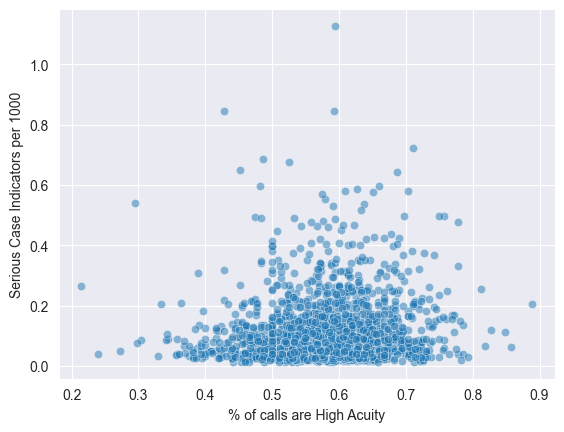

In [213]:
sns.scatterplot(filtered_weekly_data, x = '% of calls are High Acuity', y = 'Serious Case Indicators per 1000', alpha = 0.5)

In [214]:
filtered_weekly_data.loc[:, 'Serious Case Indicators per 1000 Lag +1'] = filtered_weekly_data['Serious Case Indicators per 1000'].shift(1)
filtered_weekly_data.loc[:, 'Serious Case Indicators per 1000 Lag -1'] = filtered_weekly_data['Serious Case Indicators per 1000'].shift(-1)

C:\Users\David\AppData\Local\Temp\ipykernel_37260\4142249810.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_weekly_data.loc[:, 'Serious Case Indicators per 1000 Lag +1'] = filtered_weekly_data['Serious Case Indicators per 1000'].shift(1)
C:\Users\David\AppData\Local\Temp\ipykernel_37260\4142249810.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_weekly_data.loc[:, 'Serious Case Indicators per 1000 Lag -1'] = filtered_weekly_data['Serious Case Indicators per 1000'].shift(-1)


In [215]:
def calculate_weekly_high_acuity_stats(group):
    cases = group['Serious Case Indicators per 1000']
    ems_calls = group['Weekly EMS Calls per 1000']

    if len(cases) < 3:
        return pd.Series({'correlation': np.nan, 'p_value': np.nan})

    corr, p_val = pearsonr(cases, ems_calls)
    return pd.Series({'correlation': corr, 'p_value': p_val})

In [216]:
weekly_high_acuity_stats = filtered_weekly_data.groupby('Week Start').apply(calculate_weekly_high_acuity_stats)

In [217]:
weekly_high_acuity_stats

,correlation,p_value
Week Start,,
2020-01-26,NaN,NaN
2020-02-23,NaN,NaN
2020-03-01,NaN,NaN
2020-03-08,0.181962,0.696180
2020-03-15,-0.121232,0.546933
2020-03-22,0.119034,0.395912
2020-03-29,0.067804,0.588547
2020-04-05,0.173012,0.178708
2020-04-12,0.340481,0.005906


Well, we got a few more weeks that were significant but all showed no correlation. Let's quickly look at the leads and lags and then move on.

In [218]:
def calculate_weekly_high_acuity_stats_plus_one(group):
    cases = group['Serious Case Indicators per 1000 Lag +1']
    ems_calls = group['Weekly EMS Calls per 1000']

    if len(cases) < 3:
        return pd.Series({'correlation': np.nan, 'p_value': np.nan})

    corr, p_val = pearsonr(cases, ems_calls)
    return pd.Series({'correlation': corr, 'p_value': p_val})

In [219]:
weekly_high_acuity_stats_plus_one = filtered_weekly_data.groupby('Week Start').apply(calculate_weekly_high_acuity_stats_plus_one)


In [220]:
weekly_high_acuity_stats_plus_one

,correlation,p_value
Week Start,,
2020-01-26,NaN,NaN
2020-02-23,NaN,NaN
2020-03-01,NaN,NaN
2020-03-08,-0.505696,0.246925
2020-03-15,0.259180,0.191738
2020-03-22,0.120885,0.388556
2020-03-29,0.040375,0.747548
2020-04-05,-0.081678,0.527976
2020-04-12,0.078886,0.535508


Nothing there

In [221]:
def calculate_weekly_high_acuity_stats_minus_one(group):
    cases = group['Serious Case Indicators per 1000 Lag -1']
    ems_calls = group['Weekly EMS Calls per 1000']

    if len(cases) < 3:
        return pd.Series({'correlation': np.nan, 'p_value': np.nan})

    corr, p_val = pearsonr(cases, ems_calls)
    return pd.Series({'correlation': corr, 'p_value': p_val})

In [222]:
weekly_high_acuity_stats_minus_one = filtered_weekly_data.groupby('Week Start').apply(calculate_weekly_high_acuity_stats_minus_one)


In [223]:
weekly_high_acuity_stats_minus_one

,correlation,p_value
Week Start,,
2020-01-26,NaN,NaN
2020-02-23,NaN,NaN
2020-03-01,NaN,NaN
2020-03-08,0.469946,0.287292
2020-03-15,-0.015474,0.938939
2020-03-22,-0.052322,0.709834
2020-03-29,0.079459,0.525951
2020-04-05,0.034131,0.792277
2020-04-12,0.193930,0.124666


And again, almost nothing significant.

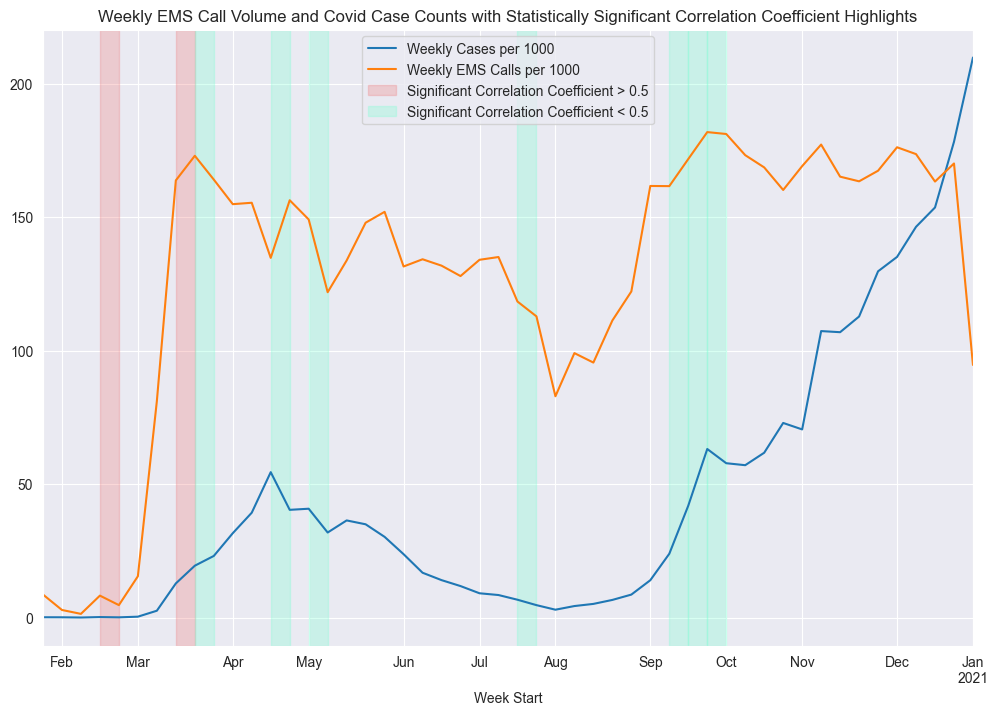

In [224]:
ax = weekly_data.reset_index().groupby('Week Start').agg({
    'Weekly Cases per 1000': 'sum',
    'Weekly EMS Calls per 1000': 'sum'
}).plot(subplots=False, figsize=(12,8))

significant_greater_than_weeks = [
    '2020-02-16',
    '2020-03-15',
]

for week in significant_greater_than_weeks:
    start_date = pd.to_datetime(week)
    end_date = start_date + pd.Timedelta(days=7)
    ax.axvspan(start_date, end_date, alpha=0.3, color='lightcoral',
               label='Significant Correlation Coefficient > 0.5' if week == significant_greater_than_weeks[0] else "")

significant_less_than_weeks = [
    '2020-09-13',
    '2020-03-22',
    '2020-09-20',
    '2020-09-27',
    '2020-05-03',
    '2020-04-19',
    '2020-07-19',
]

for week in significant_less_than_weeks:
    start_date = pd.to_datetime(week)
    end_date = start_date + pd.Timedelta(days=7)
    ax.axvspan(start_date, end_date, alpha=0.3, color='aquamarine',
               label='Significant Correlation Coefficient < 0.5' if week == significant_less_than_weeks[0] else "")
plt.title(label = 'Weekly EMS Call Volume and Covid Case Counts with Statistically Significant Correlation Coefficient Highlights')
plt.legend()
plt.show()